In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch

%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [29]:
# Cargar datos

movies = catalog.load("movies_metadata")

movies_with_clusters = catalog.load("movies_with_clusters")

X_pca = catalog.load("X_pca")   
X_tsne = catalog.load("X_tsne")  

cluster_results = catalog.load("cluster_results")

print("Datos cargados:")
print("movies_metadata:", movies.shape)
print("movies_with_clusters:", movies_with_clusters.shape)
print("X_pca:", X_pca.shape)
print("X_tsne:", X_tsne.shape)
print("keys cluster_results:", cluster_results.keys())


[11/28/25 15:37:30] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=266297;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=245937;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[11/28/25 15:37:31] INFO     Loading data from movies_with_clusters (CSVDataset)...            ]8;id=133188;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=888843;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from X_pca (ParquetDataset)...                       ]8;id=772720;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=567238;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from X_tsne (ParquetDataset)...                      ]8;id=894940;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=777981;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from cluster_results (JSONDataset)...                ]8;id=831434;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=226216;file://C:\Users\ariel\OneDrive\Desktop\Machine\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Datos cargados:
movies_metadata: (45466, 24)
movies_with_clusters: (45466, 7)
X_pca: (45466, 3)
X_tsne: (45466, 2)
keys cluster_results: dict_keys(['kmeans', 'dbscan', 'gmm'])


In [30]:
# Vistazo rápido a los datos y columnas de clusters

print("Columnas de movies_with_clusters:")
print(movies_with_clusters.columns)

print("\nPrimeras filas con clusters:")
movies_with_clusters[[
    "revenue", "runtime", "vote_average", "vote_count",
    "cluster_kmeans", "cluster_dbscan", "cluster_gmm"
]].head()


Columnas de movies_with_clusters:
Index(['revenue', 'runtime', 'vote_average', 'vote_count', 'cluster_kmeans',
       'cluster_dbscan', 'cluster_gmm'],
      dtype='object')

Primeras filas con clusters:


,revenue,runtime,vote_average,vote_count,cluster_kmeans,cluster_dbscan,cluster_gmm
0,373554033.0,81.0,7.7,5415.0,2,-1,2
1,262797249.0,104.0,6.9,2413.0,2,0,2
2,0.0,101.0,6.5,92.0,4,0,0
3,81452156.0,127.0,6.1,34.0,4,0,2
4,76578911.0,106.0,5.7,173.0,4,0,2


In [31]:
# Métricas comparativas de clustering

metricas = []

for algo, res in cluster_results.items():
    labels = np.array(res["labels"])
    n_clusters_unicos = len(set(labels) - {-1}) 

    sil = res.get("silhouette", None)
    db = res.get("davies_bouldin", None)
    ch = res.get("calinski_harabasz", None)

    metricas.append({
        "algoritmo": algo.upper(),
        "clusters_validos": n_clusters_unicos,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
    })

metricas_df = pd.DataFrame(metricas)
metricas_df


,algoritmo,clusters_validos,silhouette,davies_bouldin,calinski_harabasz
0,KMEANS,5,0.337206,0.843968,18370.839083
1,DBSCAN,4,0.641173,1.661180,2017.596176
2,GMM,5,-0.084295,2.276379,7227.133698


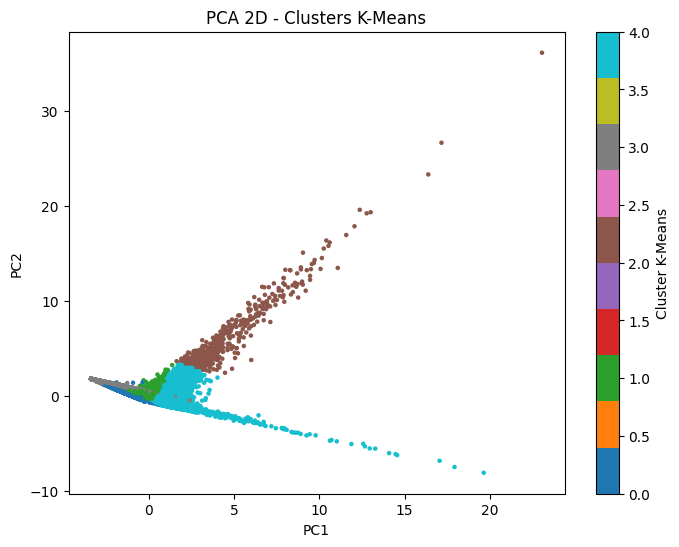

In [32]:
# Visualización PCA 2D con K-Means

if isinstance(X_pca, pd.DataFrame):
    X_pca_arr = X_pca.values
else:
    X_pca_arr = X_pca

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca_arr[:, 0],
    X_pca_arr[:, 1],
    c=movies_with_clusters["cluster_kmeans"],
    cmap="tab10",
    s=5
)
plt.title("PCA 2D - Clusters K-Means")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster K-Means")
plt.show()


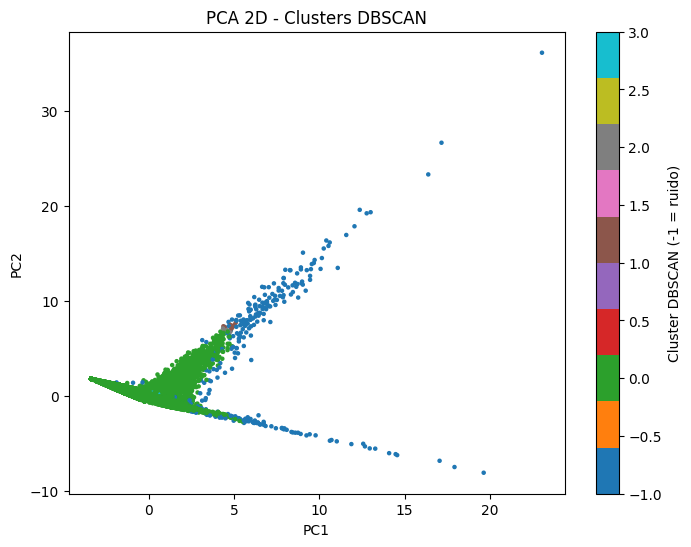

In [33]:
# PCA 2D – DBSCAN

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca_arr[:, 0],
    X_pca_arr[:, 1],
    c=movies_with_clusters["cluster_dbscan"],
    cmap="tab10",
    s=5
)
plt.title("PCA 2D - Clusters DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster DBSCAN (-1 = ruido)")
plt.show()


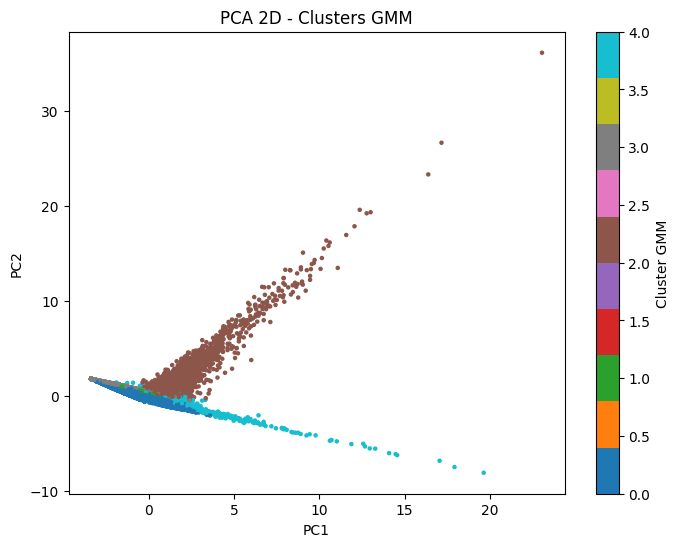

In [34]:
# 5. Visualización PCA 2D con GMM

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca_arr[:, 0],
    X_pca_arr[:, 1],
    c=movies_with_clusters["cluster_gmm"],
    cmap="tab10",
    s=5
)
plt.title("PCA 2D - Clusters GMM")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster GMM")
plt.show()


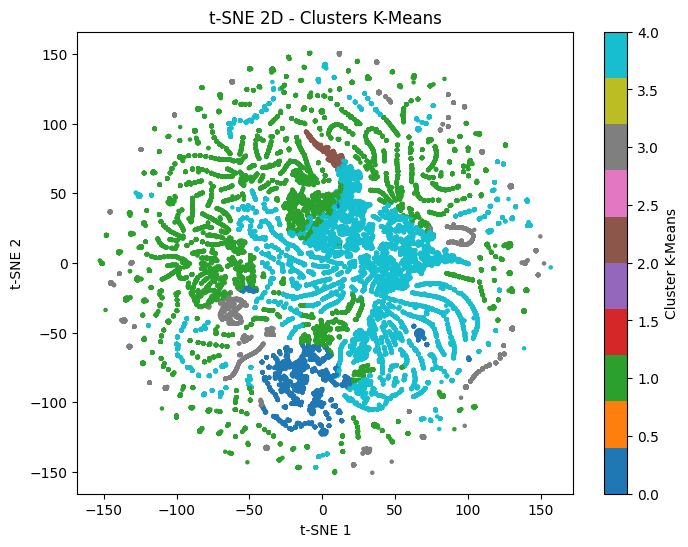

In [35]:
# Visualización t-SNE 2D con K-Means

if isinstance(X_tsne, pd.DataFrame):
    X_tsne_arr = X_tsne.values
else:
    X_tsne_arr = X_tsne

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne_arr[:, 0],
    X_tsne_arr[:, 1],
    c=movies_with_clusters["cluster_kmeans"],
    cmap="tab10",
    s=5
)
plt.title("t-SNE 2D - Clusters K-Means")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster K-Means")
plt.show()


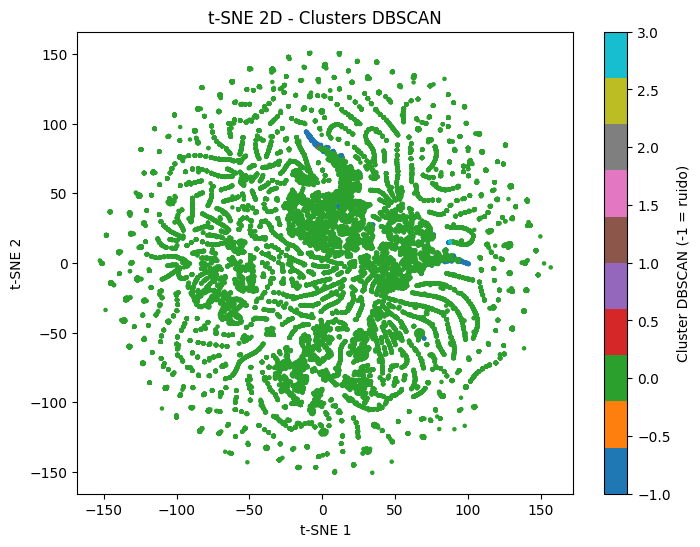

In [36]:
# t-SNE 2D – DBSCAN

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne_arr[:, 0],
    X_tsne_arr[:, 1],
    c=movies_with_clusters["cluster_dbscan"],
    cmap="tab10",
    s=5
)
plt.title("t-SNE 2D - Clusters DBSCAN")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster DBSCAN (-1 = ruido)")
plt.show()


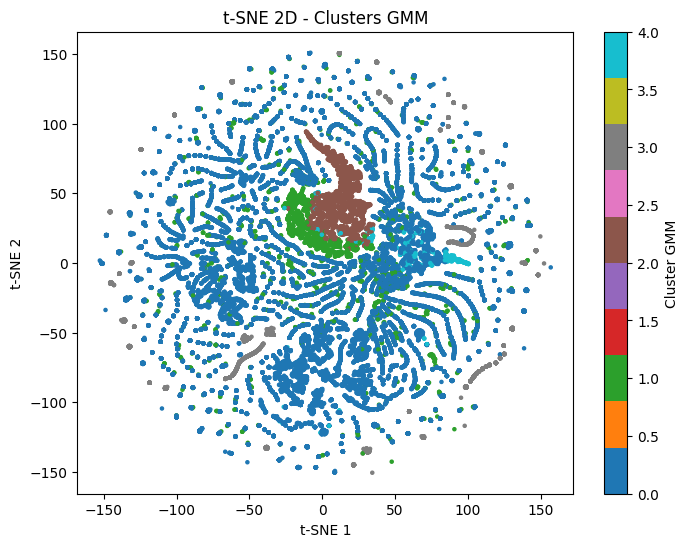

In [37]:
# Visualización t-SNE 2D con GMM

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne_arr[:, 0],
    X_tsne_arr[:, 1],
    c=movies_with_clusters["cluster_gmm"],
    cmap="tab10",
    s=5
)
plt.title("t-SNE 2D - Clusters GMM")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster GMM")
plt.show()


In [38]:
# Cluster profiling - K-Means

features = ["revenue", "runtime", "vote_average", "vote_count"]

profile_kmeans = (
    movies_with_clusters
    .groupby("cluster_kmeans")[features]
    .mean()
    .round(2)
)

print("Perfil de clusters K-Means (promedios) ")
profile_kmeans


Perfil de clusters K-Means (promedios) 


,revenue,runtime,vote_average,vote_count
cluster_kmeans,,,,
0,1.342599e+05,17.18,6.38,15.70
1,2.428255e+06,91.58,5.29,38.21
2,5.111623e+08,119.63,6.68,3269.66
3,1.761987e+04,78.24,0.34,0.87
4,1.209232e+07,113.42,6.91,146.25


In [39]:
# Cluster profiling – DBSCAN

features = ["revenue", "runtime", "vote_average", "vote_count"]

profile_dbscan = (
    movies_with_clusters
    .groupby("cluster_dbscan")[features]
    .mean()
    .round(2)
)

print("Perfil de clusters DBSCAN (promedios) ")
profile_dbscan


Perfil de clusters DBSCAN (promedios) 


,revenue,runtime,vote_average,vote_count
cluster_dbscan,,,,
-1,4.706119e+08,246.66,6.83,2993.05
0,8.137040e+06,93.14,5.61,90.87
1,5.812326e+08,106.20,6.32,2819.10
2,5.451408e+08,112.40,6.26,2999.60
3,0.000000e+00,231.56,0.00,0.00


In [40]:
# Cluster profiling - GMM

profile_gmm = (
    movies_with_clusters
    .groupby("cluster_gmm")[features]
    .mean()
    .round(2)
)

print("Perfil de clusters GMM (promedios) ")
profile_gmm


Perfil de clusters GMM (promedios) 


,revenue,runtime,vote_average,vote_count
cluster_gmm,,,,
0,1.630020e+03,91.23,5.96,25.33
1,8.282266e+06,102.99,6.15,165.55
2,1.599895e+08,111.50,6.37,1155.58
3,6.286000e+02,76.98,0.00,0.08
4,1.275985e+07,229.20,6.75,215.01


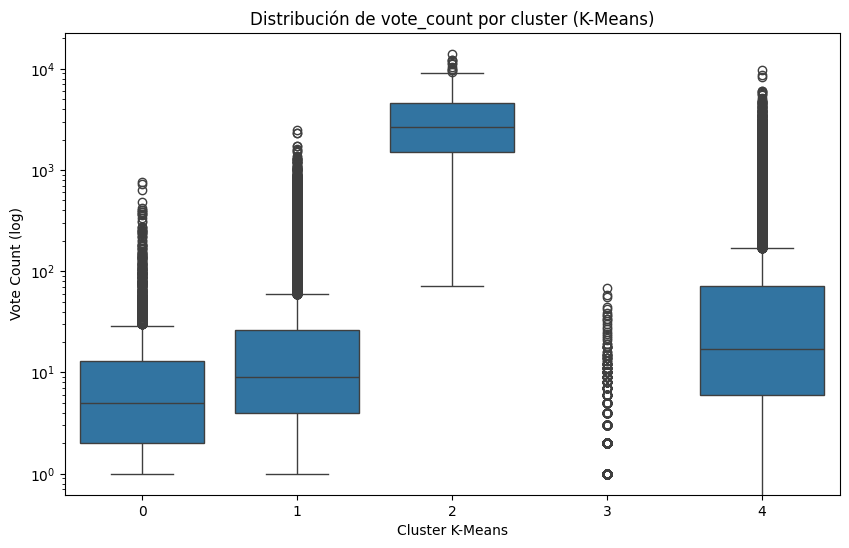

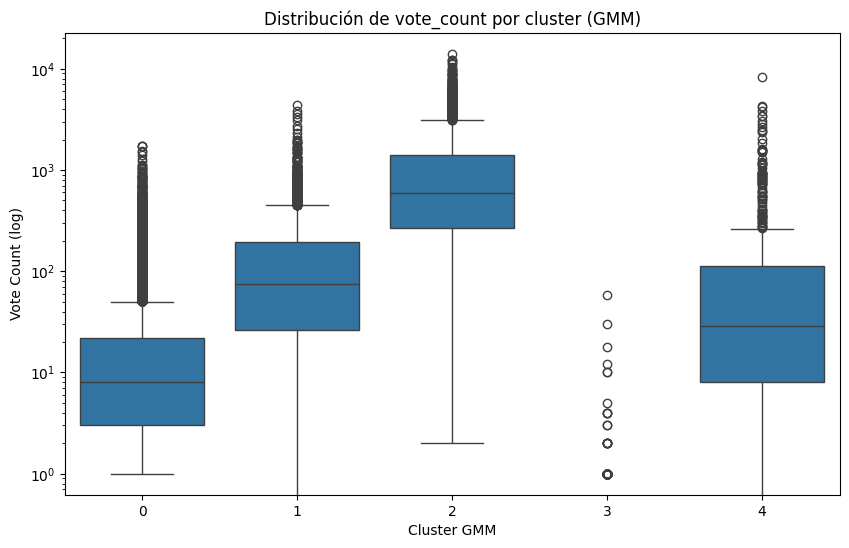

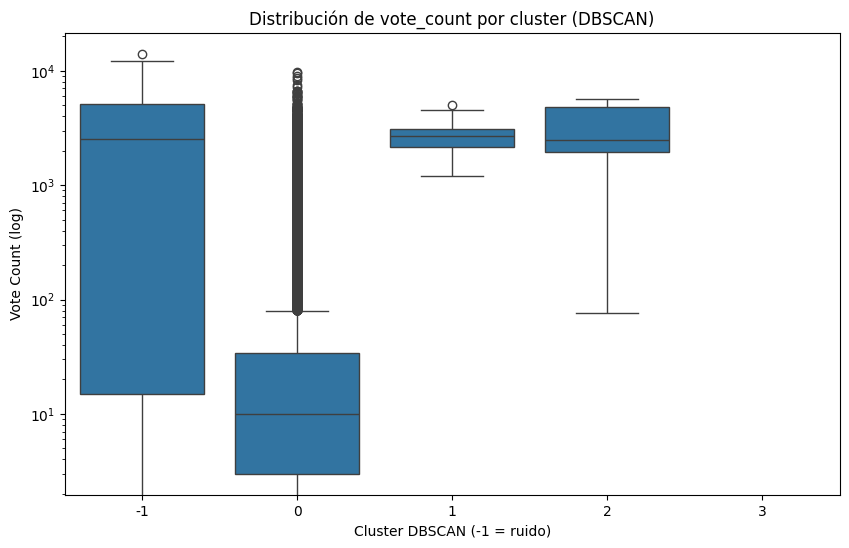

In [41]:
# Comparación: distribución de vote_count por cluster

# K-MEANS 
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=movies_with_clusters,
    x="cluster_kmeans",
    y="vote_count"
)
plt.yscale("log") 
plt.title("Distribución de vote_count por cluster (K-Means)")
plt.xlabel("Cluster K-Means")
plt.ylabel("Vote Count (log)")
plt.show()

# GMM
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=movies_with_clusters,
    x="cluster_gmm",
    y="vote_count"
)
plt.yscale("log")
plt.title("Distribución de vote_count por cluster (GMM)")
plt.xlabel("Cluster GMM")
plt.ylabel("Vote Count (log)")
plt.show()

# DBSCAN 
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=movies_with_clusters,
    x="cluster_dbscan",
    y="vote_count"
)
plt.yscale("log")
plt.title("Distribución de vote_count por cluster (DBSCAN)")
plt.xlabel("Cluster DBSCAN (-1 = ruido)")
plt.ylabel("Vote Count (log)")
plt.show()



In [42]:
#  MÉTRICAS K-MEANS
print("=== MÉTRICAS K-MEANS ===")
print("N° Clusters:", len(set(cluster_results["kmeans"]["labels"])))
print("Inertia:", cluster_results["kmeans"]["inertia"])
print("Silhouette:", cluster_results["kmeans"]["silhouette"])
print("Davies-Bouldin:", cluster_results["kmeans"]["davies_bouldin"])
print("Calinski-Harabasz:", cluster_results["kmeans"]["calinski_harabasz"])
print("\n")


#  MÉTRICAS GMM
print("=== MÉTRICAS GMM ===")
print("N° Clusters:", len(set(cluster_results["gmm"]["labels"])))
print("Silhouette:", cluster_results["gmm"]["silhouette"])
print("Davies-Bouldin:", cluster_results["gmm"]["davies_bouldin"])
print("Calinski-Harabasz:", cluster_results["gmm"]["calinski_harabasz"])
print("\n")

#  MÉTRICAS DBSCAN
valid_clusters = set(cluster_results["dbscan"]["labels"]) - {-1}

print("=== MÉTRICAS DBSCAN ===")
print("Clusters válidos (sin ruido):", len(valid_clusters))
print("Silhouette:", cluster_results["dbscan"]["silhouette"])
print("Davies-Bouldin:", cluster_results["dbscan"]["davies_bouldin"])
print("Calinski-Harabasz:", cluster_results["dbscan"]["calinski_harabasz"])



=== MÉTRICAS K-MEANS ===
N° Clusters: 5
Inertia: 52134.153649838234
Silhouette: 0.337205604794339
Davies-Bouldin: 0.8439680211254658
Calinski-Harabasz: 18370.839082918465


=== MÉTRICAS GMM ===
N° Clusters: 5
Silhouette: -0.08429538488357934
Davies-Bouldin: 2.2763793792897573
Calinski-Harabasz: 7227.133697718499


=== MÉTRICAS DBSCAN ===
Clusters válidos (sin ruido): 4
Silhouette: 0.6411732167553181
Davies-Bouldin: 1.6611804275248077
Calinski-Harabasz: 2017.596176407808
